# Validation of Missing Value Imputation Methods for Disease Onset Date
Perform cross-validation of different methods for multiple imputation based on mean/median as well as on the posterior predictive distribution (using Kullback-Leibler divergence).

## Imports

In [1]:
import pandas as pd
import numpy as np

# KL-divergence measure
from scipy.stats import entropy

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [3]:
# Plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

In [4]:
# Preprocessors
from sklearn.preprocessing import OneHotEncoder

# Imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Regressors
from sklearn.linear_model import BayesianRidge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

# Statsmodel API
import statsmodels.api as sm

# Cross-Validation
from sklearn.model_selection import cross_validate, cross_val_predict, RepeatedKFold
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [5]:
# Import own code from other directory
import sys
sys.path.append("../../code/imputation")

from imputation_methods import impute_regression, RegressionImputer, impute_pmm, PmmImputer, impute_pmm_stats

## Data Loading and Preparation

In [6]:
delay = pd.read_pickle("../../data/processed/delay.pl")

#### Summarize all observations which do not have known or binary gender

In [7]:
delay.loc[(delay["gender"]!="male") & (delay["gender"]!="female"),"gender"] = "other"

#### Remove observations with negative reporting delay

In [8]:
delay = delay[(delay["reporting_delay_hd"]>=0) | (delay["reporting_delay_hd"].isnull())]

#### One-Hot Encoding (Dummy Variables)

In [9]:
def to_dummy(X):
    enc = OneHotEncoder(handle_unknown='error',sparse=False,drop="first")
    X_cat = X.select_dtypes(include=[object,"category"])
    X_num = X.select_dtypes(exclude=[object,"category"])
    X_trans = pd.DataFrame(enc.fit_transform(X_cat),columns=enc.get_feature_names(X_cat.columns),index=X.index)
    X_dummy = pd.concat([X_num,X_trans],axis=1)
    return X_dummy, enc, X_cat.columns

def from_dummy(X, enc, cat_columns):
    X_trans = X[enc.get_feature_names(cat_columns)]
    X_num = X.drop(enc.get_feature_names(cat_columns),axis=1)
    X_cat = pd.DataFrame(enc.inverse_transform(X_trans),columns=cat_columns,index=X.index)
    X_res = pd.concat([X_num,X_cat],axis=1)
    return X_res

In [10]:
def to_coded(X):
    X = X.copy()
    X_cat = X.select_dtypes(include=[object,"category"])
    
    # define
    def map_to_int(series):
        """Convert non-numeric features to integer codes"""
        series_cat=series.astype("category")
        mapping=dict(zip(series_cat,series_cat.cat.codes))
        return series_cat.cat.codes, mapping

    mappings = {feat:map_to_int(X[feat])[1] for feat in X_cat.columns}

    # apply
    for feat,mapping in mappings.items():
        X[feat]=X[feat].replace(mapping)
        
    return X, mappings

In [11]:
delay_labels = ["reporting_delay_hd","week_report","weekday_report","age","gender","state"]
delay[delay_labels].isnull().sum()

reporting_delay_hd    47305
week_report               0
weekday_report            0
age                       0
gender                    0
state                     0
dtype: int64

In [12]:
delay_dummy, enc, enc_cats = to_dummy(delay[delay_labels])

## Imputation of Disease Onset Date
### The following methods are tested:

#### 1) Multiple Imputation using Bayesian Regression (DIY implementation)
Perform multiple imputation by drawing from Gaussian

In [13]:
onset_imputed = impute_regression(delay_dummy,"reporting_delay_hd",n=3)

#### 2) Predictive mean matching (DIY imputation) with different regression models
Perform multiple imputation by drawing randomly from the k closests instances with observed value, where closesness is defined, using a regression model, as the distance between the prediction for the missing value instance and the prediction for the observed value instance.

In [14]:
onset_imputed = impute_pmm(delay_dummy,"reporting_delay_hd",n=3)

# Cross-Validation of Imputation Approaches
To compare the performance of different imputation models, cross-validation on observed data is performed.

In [15]:
regressors = {
    "Predictive Mean Matching BR5": (PmmImputer(k_pmm=5),True),
    "Predictive Mean Matching BR10": (PmmImputer(k_pmm=10),True),
    "Predictive Mean Matching RF2": (PmmImputer(regressor=RandomForestRegressor(n_estimators=10),k_pmm=2),True),
    "Predictive Mean Matching RF5": (PmmImputer(regressor=RandomForestRegressor(n_estimators=10),k_pmm=5),True),
    "Stochastic Regression": (RegressionImputer(),True),
    "Median": (DummyRegressor(strategy="median"),False),
    "Bayesian Ridge": (BayesianRidge(),True),
    "RF Regressor": (RandomForestRegressor(n_estimators=10),True),
}

In [16]:
def getXy(data,target):
    X = data.drop(target,axis=1)
    y = data[target]
    return X, y

In [17]:
delay_cv = delay.loc[delay["reporting_delay_hd"]>=0,delay_labels].dropna()
delay_dummy_cv , enc_dummy, enc_cats_dummy = to_dummy(delay_cv)
delay_codes_cv, enc_coded = to_coded(delay_cv)

## Cross-validation of imputed values based on mean / median
The error metrics of the following cross-validation can only assess the accuracy of measures of location, not of the full distribution.

In [18]:
scorings = {'MAE': make_scorer(metrics.mean_absolute_error),
            'MRSE': make_scorer(lambda y_true, y_pred: np.sqrt(metrics.mean_squared_error(y_true, y_pred))),
            "r2": make_scorer(metrics.r2_score)}

n_repeats = 3
n_splits = 5
cv_generator = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

log = True
df_models=[]

for modelname, (model,use_dummy) in regressors.items():
    if log:
        print(f"Validating {modelname}")
    
    X, y = getXy(delay_dummy_cv if use_dummy else delay_codes_cv, "reporting_delay_hd")

    cv_results = cross_validate(model, X, y, scoring=scorings, cv=cv_generator, n_jobs=4)
    cv_results["model"]=modelname
    df_models.append(cv_results)
    
cv_results = pd.concat([pd.DataFrame(m) for m in df_models])
cv_results = cv_results[[list(cv_results.columns)[-1]] + list(cv_results.columns)[:-1]]
cv_results.groupby("model").mean()

Validating Predictive Mean Matching BR5
Validating Predictive Mean Matching BR10
Validating Predictive Mean Matching RF2
Validating Predictive Mean Matching RF5
Validating Stochastic Regression
Validating Median
Validating Bayesian Ridge
Validating RF Regressor


,fit_time,score_time,test_MAE,test_MRSE,test_r2
model,,,,,
Bayesian Ridge,0.403188,0.035186,3.562418,4.950791,0.030771
Median,0.009637,0.004809,3.516363,5.094412,-0.026577
Predictive Mean Matching BR10,0.432570,0.113702,4.887723,6.937434,-0.893513
Predictive Mean Matching BR5,0.342085,0.091676,4.884625,6.956891,-0.900176
Predictive Mean Matching RF2,2.684069,0.206318,4.753937,6.817057,-0.835532
Predictive Mean Matching RF5,2.491734,0.213229,4.755270,6.798974,-0.829395
RF Regressor,2.440563,0.166273,3.952970,5.579806,-0.231409
Stochastic Regression,0.249649,1.928447,5.358882,7.003907,-0.947018


## Cross-validation based on full posterior distribution

#### Integration of CV-data from external approaches by Michael Hoehle

In [19]:
hoehle = pd.read_csv("../../data/imputed_hoehle_3.csv",parse_dates=["rep_date","disease_start","disease_start_imp"],encoding = "ISO-8859-1")
hoehle = hoehle.assign(reporting_delay_hd = lambda x: (x.rep_date-x.disease_start).dt.days,
                      reporting_delay_hd_imp = lambda x: (x.rep_date-x.disease_start_imp).dt.days) # estimated delay
# remove observations which are too recent
hoehle = hoehle.query("rep_date<'2020-04-14'")
# remove observations with negative reporting delay
hoehle = hoehle[(hoehle["reporting_delay_hd"]>=0) | (hoehle["reporting_delay_hd"].isnull())]

# compute estimated date of onset
hoehle = hoehle.assign(date_onset_imp=lambda x: (x.rep_date-pd.to_timedelta(x.reporting_delay_hd_imp,"days")))

# rename
hoehle = hoehle.rename(columns={"disease_start":"date_onset","rep_date":"date_report","sex":"gender","Id":"id"})
hoehle["gender"] = hoehle["gender"].replace({"männlich":"male","weiblich":"female"})
hoehle.loc[(hoehle["gender"]!="male") & (hoehle["gender"]!="female"),"gender"] = "other"

datecols = [
    x for x in hoehle.columns if "date" in x.lower()
]  # select all columns featuring a date


# Add calender week for all date columns
for col in datecols:
    hoehle[col.replace("date", "week")] = hoehle[col].dt.week

# Add day of the week for all date columns
def as_ordered_weekday(col):
    return col.astype(pd.CategoricalDtype(ordered=True)).cat.reorder_categories(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
        ordered=True,
    )

for col in datecols:
    hoehle[col.replace("date", "weekday")] = as_ordered_weekday(hoehle[col].dt.day_name())
    
hoehle["age_group1"] = hoehle[["id","age"]].merge(delay[["age","age_group1"]].drop_duplicates(),how="left")["age_group1"].to_numpy()

In [20]:
hoehle_state = pd.read_csv("../../data/imputed_hoehle_state.csv",parse_dates=["rep_date","disease_start","disease_start_imp"],encoding = "ISO-8859-1")
hoehle_state = hoehle_state.assign(reporting_delay_hd = lambda x: (x.rep_date-x.disease_start).dt.days,
                      reporting_delay_hd_imp = lambda x: (x.rep_date-x.disease_start_imp).dt.days) # estimated delay
# remove observations which are too recent
hoehle_state = hoehle_state.query("rep_date<'2020-04-14'")
# remove observations with negative reporting delay
hoehle_state = hoehle_state[(hoehle_state["reporting_delay_hd"]>=0) | (hoehle_state["reporting_delay_hd"].isnull())]

# compute estimated date of onset
hoehle_state = hoehle_state.assign(date_onset_imp=lambda x: (x.rep_date-pd.to_timedelta(x.reporting_delay_hd_imp,"days")))

# rename
hoehle_state = hoehle_state.rename(columns={"disease_start":"date_onset","rep_date":"date_report","sex":"gender","Id":"id"})
hoehle_state["gender"] = hoehle_state["gender"].replace({"männlich":"male","weiblich":"female"})
hoehle_state.loc[(hoehle_state["gender"]!="male") & (hoehle_state["gender"]!="female"),"gender"] = "other"

datecols = [
    x for x in hoehle_state.columns if "date" in x.lower()
]  # select all columns featuring a date


# Add calender week for all date columns
for col in datecols:
    hoehle_state[col.replace("date", "week")] = hoehle_state[col].dt.week

# Add day of the week for all date columns
def as_ordered_weekday(col):
    return col.astype(pd.CategoricalDtype(ordered=True)).cat.reorder_categories(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
        ordered=True,
    )

for col in datecols:
    hoehle_state[col.replace("date", "weekday")] = as_ordered_weekday(hoehle_state[col].dt.day_name())
    
hoehle_state["age_group1"] = hoehle_state[["id","age"]].merge(delay[["age","age_group1"]].drop_duplicates(),how="left")["age_group1"].to_numpy()

Define set of imputed values

In [21]:
use_all_folds = True
if use_all_folds:
    # using all folds
    (model,use_dummy) = regressors["Stochastic Regression"]
    X, y = getXy(delay_dummy_cv if use_dummy else delay_codes_cv, "reporting_delay_hd")
    imputed_reg = cross_val_predict(model, X, y, cv = 3)

    (model,use_dummy) = regressors["Predictive Mean Matching BR5"]
    X, y = getXy(delay_dummy_cv if use_dummy else delay_codes_cv, "reporting_delay_hd")
    imputed_pmm_br = cross_val_predict(model, X, y, cv = 3)

    (model,use_dummy) = regressors["Predictive Mean Matching RF5"]
    X, y = getXy(delay_dummy_cv if use_dummy else delay_codes_cv, "reporting_delay_hd")
    imputed_pmm_forest = cross_val_predict(model, X, y, cv = 3)

    hoehle_imp = hoehle["reporting_delay_hd_imp"].to_numpy()
    hoehle_state_imp = hoehle_state["reporting_delay_hd_imp"].to_numpy()

    imputed = {"reg":imputed_reg,"pmm_br":imputed_pmm_br,"pmm_forest":imputed_pmm_forest}
else:
    # using only one fold
    X, y = getXy(delay_dummy_cv, "reporting_delay_hd")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    (model,use_dummy) = regressors["Stochastic Regression"]
    model.fit(X_train,y_train)
    imputed_reg = model.predict(X_test)

    (model,use_dummy) = regressors["Predictive Mean Matching BR5"]
    model.fit(X_train,y_train)
    imputed_pmm_br = model.predict(X_test)

    (model,use_dummy) = regressors["Predictive Mean Matching RF5"]
    model.fit(X_train,y_train)
    imputed_pmm_forest = model.predict(X_test)

    hoehle_imp = hoehle.query("fold==1")["reporting_delay_hd_imp"].to_numpy()
    hoehle_state_imp = hoehle_state["reporting_delay_hd_imp"].to_numpy()

    imputed = {"reg":imputed_reg,"pmm_br":imputed_pmm_br,"pmm_forest":imputed_pmm_forest}
    y = y_test

### Computation of Kullback-Leibler Divergence

In [22]:
def compute_kl(arr1,arr2,vrange):
    """
    Compute Kullback-Leibler divergence between two discrete distributions, given samples from each distribution.
    
    Parameters
    ----------
    arr1, arr2 : array_like
        Arrays of samples from two distributions to compare.
    vrange : iterable
        Iterable with valid values from the support of the probability distributions.
        
    """
    arr1_c = pd.Series(arr1).round().value_counts().sort_index().reindex(vrange).fillna(0.00001)
    arr2_c = pd.Series(arr2).round().value_counts().sort_index().reindex(vrange).fillna(0.00001)
    return entropy(arr1_c,arr2_c)

In [23]:
def kl_div_strata_dummy(X,y,imputed,strata,remaining):
    """Compute Kullback-Leibler divergence on stratified dataset with one-hot encoding"""
    kl_results = dict()
    for k,v in strata.iterrows():
        sub_idx = (X[list(v.index)]==v).all(axis=1).to_numpy()
        if v.any():
            strat_name = strata.columns[list(v.astype(bool))][0]
        else:
            strat_name = remaining

        strat_res = {k_imp:compute_kl(y[sub_idx],imp[sub_idx],range(25)) for k_imp, imp in imputed.items()}
        
        kl_results[strat_name] = strat_res
    return kl_results

def kl_div_strata_cat(X,y,imputed,strata):
    """Compute Kullback-Leibler divergence on stratified dataset without one-hot encoding"""
    kl_results = dict()
    for k,v in strata.iterrows():
        sub_idx = (X[list(v.index)]==v).all(axis=1).to_numpy()
        strat_name = v.iloc[0]

        strat_res = {k_imp:compute_kl(y[sub_idx],imp[sub_idx],range(25)) for k_imp, imp in imputed.items()}
        
        kl_results[strat_name] = strat_res
    return kl_results

#### All

In [24]:
pd.DataFrame({"All":{k_imp:compute_kl(y,imp,range(25)) for k_imp, imp in {**imputed,"hoehle":hoehle_imp,"hoehle_state":hoehle_state_imp}.items()}}).assign(Rank = lambda x: x.rank())

,All,Rank
hoehle,0.011900,3.0
hoehle_state,0.011242,2.0
pmm_br,0.063251,4.0
pmm_forest,0.004284,1.0
reg,0.120044,5.0


#### Gender

In [25]:
strata_subs = ["gender_male","gender_other"]
remaining = "gender_female"
strata = X[strata_subs].drop_duplicates()
a = pd.DataFrame(kl_div_strata_dummy(X,y,imputed,strata,remaining))
a = a.rename(columns={col:col.replace("gender_","") for col in a.columns})

strata = hoehle[["gender"]].drop_duplicates()
h = pd.DataFrame(kl_div_strata_cat(hoehle,hoehle["reporting_delay_hd"],{"hoehle":hoehle["reporting_delay_hd_imp"]},strata))

strata = hoehle_state[["gender"]].drop_duplicates()
hs = pd.DataFrame(kl_div_strata_cat(hoehle_state,hoehle_state["reporting_delay_hd"],{"hoehle_state":hoehle_state["reporting_delay_hd_imp"]},strata))

print({k:v.index[v][0] for k,v in (pd.concat([a,h,hs],sort=True).rank()==1).iteritems()})
pd.merge(pd.concat([a,h,hs],sort=True),pd.concat([a,h,hs],sort=True).rank(),left_index=True,right_index=True,suffixes=["","_rank"],sort=True)

{'female': 'pmm_forest', 'male': 'pmm_forest', 'other': 'pmm_forest'}


,female,male,other,female_rank,male_rank,other_rank
hoehle,0.010526,0.010913,0.679957,2.0,3.0,4.0
hoehle_state,0.010536,0.008999,0.629279,3.0,2.0,3.0
pmm_br,0.058007,0.069805,0.890273,4.0,4.0,5.0
pmm_forest,0.004798,0.004844,0.160432,1.0,1.0,1.0
reg,0.128592,0.113674,0.442244,5.0,5.0,2.0


#### Weekday

In [26]:
strata_subs = ['weekday_report_Monday','weekday_report_Saturday', 'weekday_report_Sunday','weekday_report_Thursday', 'weekday_report_Tuesday','weekday_report_Wednesday']
remaining = "weekday_report_Friday"
strata = X[strata_subs].drop_duplicates()
a = pd.DataFrame(kl_div_strata_dummy(X,y,imputed,strata,remaining))
a = a.rename(columns={col:col.replace("weekday_report_","") for col in a.columns})

strata = hoehle[["weekday_report"]].drop_duplicates()
h = pd.DataFrame(kl_div_strata_cat(hoehle,hoehle["reporting_delay_hd"],{"hoehle":hoehle["reporting_delay_hd_imp"]},strata))

strata = hoehle_state[["weekday_report"]].drop_duplicates()
hs = pd.DataFrame(kl_div_strata_cat(hoehle_state,hoehle_state["reporting_delay_hd"],{"hoehle_state":hoehle_state["reporting_delay_hd_imp"]},strata))

print({k:v.index[v][0] for k,v in (pd.concat([a,h,hs],sort=True).rank()==1).iteritems()})
pd.merge(pd.concat([a,h,hs],sort=True),pd.concat([a,h,hs],sort=True).rank(),left_index=True,right_index=True,suffixes=["","_rank"],sort=True)

{'Friday': 'hoehle', 'Monday': 'pmm_forest', 'Saturday': 'hoehle_state', 'Sunday': 'pmm_forest', 'Thursday': 'pmm_forest', 'Tuesday': 'pmm_forest', 'Wednesday': 'pmm_forest'}


,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Friday_rank,Monday_rank,Saturday_rank,Sunday_rank,Thursday_rank,Tuesday_rank,Wednesday_rank
hoehle,0.013413,0.019453,0.017067,0.018707,0.013972,0.015423,0.015823,1.0,2.0,3.0,3.0,3.0,3.0,3.0
hoehle_state,0.017520,0.021258,0.013409,0.017124,0.012330,0.010902,0.013360,3.0,3.0,1.0,2.0,2.0,2.0,2.0
pmm_br,0.053261,0.131189,0.062588,0.089394,0.065557,0.057370,0.054816,4.0,4.0,4.0,4.0,4.0,4.0,4.0
pmm_forest,0.016510,0.019284,0.015922,0.013781,0.009601,0.010439,0.011483,2.0,1.0,2.0,1.0,1.0,1.0,1.0
reg,0.141540,0.132130,0.138508,0.132518,0.126370,0.116505,0.112965,5.0,5.0,5.0,5.0,5.0,5.0,5.0


#### State

In [27]:
strata_subs = ['state_Bayern', 'state_Berlin', 'state_Brandenburg', 'state_Bremen',
       'state_Hamburg', 'state_Hessen', 'state_Mecklenburg-Vorpommern',
       'state_Niedersachsen', 'state_Nordrhein-Westfalen',
       'state_Rheinland-Pfalz', 'state_Saarland', 'state_Sachsen',
       'state_Sachsen-Anhalt', 'state_Schleswig-Holstein', 'state_Thüringen']
remaining = "state_Baden-Württemberg"
strata = X[strata_subs].drop_duplicates()
a = pd.DataFrame(kl_div_strata_dummy(X,y,imputed,strata,remaining))
a = a.rename(columns={col:col.replace("state_","") for col in a.columns})

strata = hoehle[["state"]].drop_duplicates()
h = pd.DataFrame(kl_div_strata_cat(hoehle,hoehle["reporting_delay_hd"],{"hoehle":hoehle["reporting_delay_hd_imp"]},strata))

strata = hoehle_state[["state"]].drop_duplicates()
hs = pd.DataFrame(kl_div_strata_cat(hoehle_state,hoehle_state["reporting_delay_hd"],{"hoehle_state":hoehle_state["reporting_delay_hd_imp"]},strata))

print({k:v.index[v][0] for k,v in (pd.concat([a,h,hs],sort=True).rank()==1).iteritems()})
pd.merge(pd.concat([a,h,hs],sort=True),pd.concat([a,h,hs],sort=True).rank(),left_index=True,right_index=True,suffixes=["","_rank"],sort=True)

{'Baden-Württemberg': 'pmm_forest', 'Bayern': 'hoehle_state', 'Berlin': 'hoehle_state', 'Brandenburg': 'hoehle_state', 'Bremen': 'pmm_forest', 'Hamburg': 'pmm_forest', 'Hessen': 'hoehle_state', 'Mecklenburg-Vorpommern': 'hoehle_state', 'Niedersachsen': 'pmm_forest', 'Nordrhein-Westfalen': 'pmm_forest', 'Rheinland-Pfalz': 'pmm_forest', 'Saarland': 'hoehle', 'Sachsen': 'hoehle_state', 'Sachsen-Anhalt': 'pmm_br', 'Schleswig-Holstein': 'hoehle', 'Thüringen': 'hoehle_state'}


,Baden-Württemberg,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen,Baden-Württemberg_rank,Bayern_rank,Berlin_rank,Brandenburg_rank,Bremen_rank,Hamburg_rank,Hessen_rank,Mecklenburg-Vorpommern_rank,Niedersachsen_rank,Nordrhein-Westfalen_rank,Rheinland-Pfalz_rank,Saarland_rank,Sachsen_rank,Sachsen-Anhalt_rank,Schleswig-Holstein_rank,Thüringen_rank
hoehle,0.010704,0.024342,0.029077,0.039198,0.166190,0.022967,0.044253,0.108697,0.017217,0.012363,0.029898,0.018989,0.066939,0.145896,0.020903,0.067328,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,3.0,1.0,4.0,4.0,1.0,4.0
hoehle_state,0.012054,0.008327,0.009461,0.028853,0.242547,0.027876,0.016529,0.059542,0.013760,0.014732,0.013907,0.026983,0.023675,0.104828,0.030064,0.047837,3.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0,1.0
pmm_br,0.031277,0.112500,0.135287,0.046006,0.241616,0.030170,0.131420,0.192735,0.031656,0.082503,0.088637,0.186621,0.024629,0.095315,0.055915,0.060946,4.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,4.0,4.0,4.0,4.0,2.0,1.0,3.0,3.0
pmm_forest,0.006539,0.035970,0.022137,0.051974,0.090441,0.013242,0.019934,0.202567,0.011621,0.006282,0.012211,0.132791,0.051272,0.127251,0.067532,0.050294,1.0,3.0,2.0,4.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,2.0
reg,0.112890,0.093047,0.102939,0.236201,0.339408,0.165774,0.121386,0.281233,0.132250,0.135939,0.145355,0.300856,0.187800,0.323515,0.149420,0.241402,5.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


#### Age

In [28]:
strata = delay.loc[delay["reporting_delay_hd"]>=0,["age_group1"]].dropna().drop_duplicates()
a = pd.DataFrame(kl_div_strata_cat(delay.loc[delay["reporting_delay_hd"]>=0,["age_group1"]].dropna(),y,imputed,strata))

strata = hoehle[["age_group1"]].drop_duplicates()
h = pd.DataFrame(kl_div_strata_cat(hoehle,hoehle["reporting_delay_hd"],{"hoehle":hoehle["reporting_delay_hd_imp"]},strata))

strata = hoehle_state[["age_group1"]].drop_duplicates()
hs = pd.DataFrame(kl_div_strata_cat(hoehle_state,hoehle_state["reporting_delay_hd"],{"hoehle_state":hoehle_state["reporting_delay_hd_imp"]},strata))

print({k:v.index[v][0] for k,v in (pd.concat([a,h,hs],sort=True).rank()==1).iteritems()})
pd.merge(pd.concat([a,h,hs],sort=True),pd.concat([a,h,hs],sort=True).rank(),left_index=True,right_index=True,suffixes=["","_rank"],sort=True)

{'0 - 4': 'hoehle', '15 - 34': 'hoehle_state', '35 - 59': 'pmm_forest', '5 - 14': 'pmm_forest', '60 - 79': 'pmm_forest', '80+': 'hoehle', 'unbekannt': 'reg'}


,0 - 4,15 - 34,35 - 59,5 - 14,60 - 79,80+,unbekannt,0 - 4_rank,15 - 34_rank,35 - 59_rank,5 - 14_rank,60 - 79_rank,80+_rank,unbekannt_rank
hoehle,0.070947,0.010817,0.015969,0.044338,0.016375,0.038405,0.652363,1.0,2.0,3.0,2.0,2.0,1.0,3.0
hoehle_state,0.102880,0.010029,0.013398,0.054419,0.019167,0.047938,2.808987,3.0,1.0,2.0,3.0,3.0,2.0,5.0
pmm_br,0.252934,0.091808,0.056906,0.201177,0.038830,0.190153,1.357423,4.0,4.0,4.0,4.0,4.0,4.0,4.0
pmm_forest,0.081469,0.011651,0.004351,0.039569,0.006974,0.063905,0.558883,2.0,3.0,1.0,1.0,1.0,3.0,2.0
reg,0.314135,0.133909,0.112022,0.259198,0.079236,0.343321,0.448882,5.0,5.0,5.0,5.0,5.0,5.0,1.0


#### Week

In [29]:
strata = X[["week_report"]].drop_duplicates()
a = pd.DataFrame(kl_div_strata_cat(X[["week_report"]],y,imputed,strata))

strata = hoehle[["week_report"]].drop_duplicates()
h = pd.DataFrame(kl_div_strata_cat(hoehle,hoehle["reporting_delay_hd"],{"hoehle":hoehle["reporting_delay_hd_imp"]},strata))


strata = hoehle_state[["week_report"]].drop_duplicates()
hs = pd.DataFrame(kl_div_strata_cat(hoehle_state,hoehle_state["reporting_delay_hd"],{"hoehle_state":hoehle_state["reporting_delay_hd_imp"]},strata))

print({k:v.index[v][0] for k,v in (pd.concat([a,h,hs],sort=True).rank()==pd.concat([a,h,hs],sort=True).rank().min()).iteritems()})
pd.merge(pd.concat([a,h,hs],sort=True),pd.concat([a,h,hs],sort=True).rank(),left_index=True,right_index=True,suffixes=["","_rank"],sort=True)

{5: 'hoehle_state', 6: 'hoehle', 7: 'reg', 9: 'pmm_br', 10: 'hoehle_state', 11: 'pmm_forest', 12: 'hoehle_state', 13: 'pmm_forest', 14: 'pmm_br', 15: 'hoehle', 16: 'pmm_forest'}


,5,6,7,9,10,11,12,13,14,15,16,5_rank,6_rank,7_rank,9_rank,10_rank,11_rank,12_rank,13_rank,14_rank,15_rank,16_rank
hoehle,4.678029,2.579682,11.510048,1.368842,0.166582,0.096945,0.044351,0.043234,0.010236,0.031050,0.185300,2.5,1.0,3.0,5.0,4.0,3.0,2.0,4.0,3.0,1.0,2.0
hoehle_state,3.132385,7.022497,11.510048,0.777364,0.090070,0.075730,0.038384,0.044527,0.007785,0.035303,0.198952,1.0,4.0,3.0,3.0,1.0,2.0,1.0,5.0,2.0,2.0,3.0
pmm_br,4.735933,2.856928,11.510048,0.449816,0.144019,0.210247,0.108217,0.035536,0.003259,0.850721,4.340084,4.0,2.0,3.0,1.0,3.0,4.0,4.0,3.0,1.0,5.0,5.0
pmm_forest,4.678029,4.882166,11.510048,0.775890,0.129812,0.051713,0.082983,0.010525,0.028765,0.095587,0.152713,2.5,3.0,3.0,2.0,2.0,1.0,3.0,1.0,4.0,3.0,1.0
reg,6.578580,9.764332,11.510048,0.852028,0.227954,0.468676,0.292872,0.033287,0.080368,0.438136,0.693194,5.0,5.0,3.0,4.0,5.0,5.0,5.0,2.0,5.0,4.0,4.0


#### KL divergence generalization error using scikit-learn's CV-scheme

In [30]:
# Custom KL divergence scorer
class kl_scorer():
    """
    Custom scikit-learn scorer for Kullback-Leibler divergence.
    
    Parameters
    ----------
    strata : DataFrame
        Single-row dataframe with stratum feature values as columns.
    pred_range : iterable
        Iterable with valid values from the support of the probability distributions.
        
    """
    def __init__(self,strata=None,pred_range=range(100)):
        self.strata = strata
        self.remaining = remaining
        self.pred_range = pred_range
    
    def __call__(self, estimator, X, y_true, sample_weight=None):
        y_pred = estimator.predict(X)
        if self.strata is not None:
            X_nondummy = from_dummy(X, enc_dummy, enc_cats_dummy)
            strat_idx = (X_nondummy[list(self.strata.index)]==self.strata).all(axis=1)         
        else:
            strat_idx = list(range(len(y_true)))
        return compute_kl(y_true[strat_idx],y_pred[strat_idx],self.pred_range)

In [31]:
regressors = {
    "Predictive Mean Matching BR5": (PmmImputer(),True),
    "Predictive Mean Matching BR10": (PmmImputer(k_pmm=10),True),
    "Predictive Mean Matching RF5": (PmmImputer(regressor=RandomForestRegressor(n_estimators=10),k_pmm=5),True),
    "Stochastic Regression": (RegressionImputer(),True)
}

In [32]:
strata = delay.loc[delay["reporting_delay_hd"]>=0,["gender"]].dropna().drop_duplicates()

In [33]:
delay_cv = delay.loc[delay["reporting_delay_hd"]>=0,delay_labels].dropna()
delay_dummy_cv , enc_dummy, enc_cats_dummy = to_dummy(delay_cv)
delay_codes_cv, enc_coded = to_coded(delay_cv)

def getXy(data,target):
    X = data.drop(target,axis=1)
    y = data[target]
    return X, y

scorings = {'MAE': make_scorer(metrics.mean_absolute_error),
            'MRSE': make_scorer(lambda y_true, y_pred: np.sqrt(metrics.mean_squared_error(y_true, y_pred))),
            "r2": make_scorer(metrics.r2_score),
            "KL-Divergence": kl_scorer()}

scorings = {str(v.to_dict()):kl_scorer(strata=v,pred_range=range(25)) for k,v in strata.iterrows()}

log = True
df_models=[]

for modelname, (model,use_dummy) in regressors.items():
    if log:
        print(f"Validating {modelname}")
    
    X, y = getXy(delay_dummy_cv if use_dummy else delay_codes_cv, "reporting_delay_hd")

    cv_results = cross_validate(model, X, y, scoring=scorings, cv=3, n_jobs=None, verbose=0)
    cv_results["model"]=modelname
    df_models.append(cv_results)
    
cv_results = pd.concat([pd.DataFrame(m) for m in df_models])
cv_results = cv_results[[list(cv_results.columns)[-1]] + list(cv_results.columns)[:-1]]
cv_results.groupby("model").mean()

Validating Predictive Mean Matching BR5
Validating Predictive Mean Matching BR10
Validating Predictive Mean Matching RF5
Validating Stochastic Regression


,fit_time,score_time,test_{'gender': 'male'},test_{'gender': 'female'},test_{'gender': 'other'}
model,,,,,
Predictive Mean Matching BR10,0.072107,0.151222,0.175744,0.136726,3.213816
Predictive Mean Matching BR5,0.082175,0.145773,0.179733,0.131408,1.385377
Predictive Mean Matching RF5,1.436238,0.302334,0.041903,0.051737,2.911572
Stochastic Regression,0.068039,2.686720,0.178307,0.186391,2.071364


## Visualization of the delay distribution

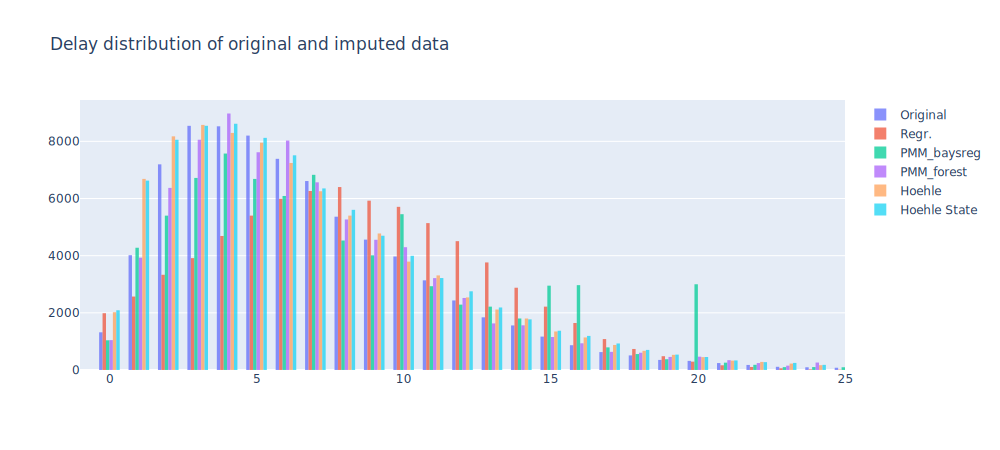

In [34]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=y,name="Original",))
fig.add_trace(go.Histogram(x=imputed_reg,name="Regr."))
fig.add_trace(go.Histogram(x=imputed_pmm_br,name="PMM_baysreg"))
fig.add_trace(go.Histogram(x=imputed_pmm_forest,name="PMM_forest"))
fig.add_trace(go.Histogram(x=hoehle_imp,name="Hoehle"))
fig.add_trace(go.Histogram(x=hoehle_state_imp,name="Hoehle State"))

# Overlay both histograms
fig.update_layout(barmode='group',bargap=0.3,title="Delay distribution of original and imputed data",xaxis=dict(range=[-1,25]))
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show(width=1000,renderer="svg")

### Visualization of the Disease Onset Time Series

In [35]:
imputers = {k:v for k,v in regressors.items() if k in ["Stochastic Regression","Predictive Mean Matching BR5","Predictive Mean Matching RF5"]}

In [36]:
def to_onset_df(prediction,id_):
    day_onset_temp = delay.loc[delay_cv.index]["day_report"] - prediction
    date_onset_temp = pd.to_datetime("2020-01-01")+pd.to_timedelta(day_onset_temp,unit="days")

    return pd.DataFrame(dict(trace=id_, date_onset=date_onset_temp))

X, y = getXy(delay_dummy_cv, "reporting_delay_hd")
onset = pd.concat(
    [to_onset_df(cross_val_predict(imputer[0], X, y, cv = 3),id) for id,imputer in imputers.items()] +
    [pd.DataFrame(dict(trace="hoehle",date_onset=hoehle["date_onset_imp"])),
     pd.DataFrame(dict(trace="hoehle_state",date_onset=hoehle_state["date_onset_imp"])),
     pd.DataFrame(dict(trace="original",date_onset=delay.loc[delay_cv.index]["date_onset"]))]
)
#pd.DataFrame(dict(trace="report",date_onset=delay.loc[delay_cv.index]["date_report"]))

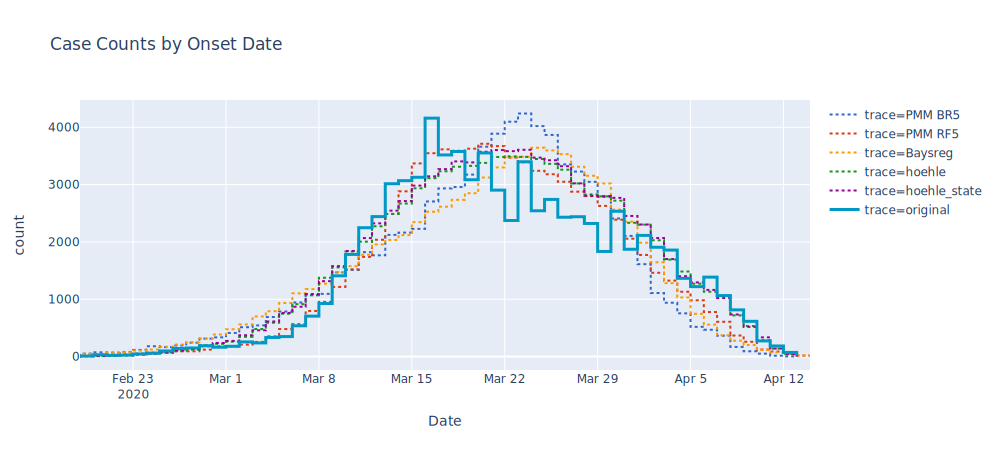

In [37]:
onset_count = onset.groupby(["date_onset","trace"]).size().reset_index().rename(columns={0:"count"})
onset_count = onset_count.sort_values(["trace","date_onset"])
onset_count["trace"] = onset_count["trace"].str.replace("Predictive Mean Matching","PMM").str.replace("Stochastic Regression","Baysreg")

fig = px.line(onset_count, x='date_onset', y='count', title="Case Counts by Onset Date",labels={"date_onset":"Date"},color="trace",line_shape='hv',color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(xaxis_range=[pd.to_datetime("2020-02-19"),pd.to_datetime("2020-04-14")])
fig.for_each_trace(
    lambda trace: trace.update(line = dict(width=3)) if trace.name == "trace=original" else trace.update(line = dict(dash="dot")),
)

fig.show(width=1000,renderer="svg")

#### KL divergence for disease onset

In [38]:
onset = onset.assign(day_onset=lambda x: (x.date_onset - pd.to_datetime("2020-01-01")).dt.days)
{trace: compute_kl(onset.query("trace=='original'")["day_onset"],onset.query(f"trace=='{trace}'")["day_onset"],range(100)
           ) for trace in onset["trace"].unique()}

{'Predictive Mean Matching BR5': 0.094708632915066,
 'Predictive Mean Matching RF5': 0.027623858710019468,
 'Stochastic Regression': 0.08200903150030546,
 'hoehle': 0.029780742898004656,
 'hoehle_state': 0.027476622282098514,
 'original': 0.0}

## Deprecated Imputation Code

### Single Imputation with Regression (Scikit-learn iterative imputer)

In [39]:
imp = IterativeImputer(random_state=0, estimator=BayesianRidge(), sample_posterior=True, max_iter=1)

In [40]:
imp.fit(delay_dummy)

IterativeImputer(add_indicator=False,
                 estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                         compute_score=False, copy_X=True,
                                         fit_intercept=True, lambda_1=1e-06,
                                         lambda_2=1e-06, n_iter=300,
                                         normalize=False, tol=0.001,
                                         verbose=False),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=1, max_value=None, min_value=None, missing_values=nan,
                 n_nearest_features=None, random_state=0, sample_posterior=True,
                 tol=0.001, verbose=0)

In [41]:
onset_imputed = pd.DataFrame({"imputation_01":imp.transform(delay_dummy)[:,0]}).round().astype(int)

### Multiple Imputation with Predictive Mean Matching (Statsmodel)

In [42]:
def impute_pmm_stats(target,data,k_pmm=5,n=1):
    data_anonymous = data.copy()
    data_anonymous.columns = [f"x{i}" for i in range(data_anonymous.shape[1])]
    imp = sm.MICEData(data_anonymous,k_pmm=k_pmm)
    return pd.DataFrame({f"imputation_{i:02d}":imp.next_sample()["x0"].copy() for i in range(n)},index=data.index)

In [44]:
onset_imputed = impute_pmm_stats("reporting_delay_hd",delay_dummy,n=3)

In [45]:
onset_imputed

,imputation_00,imputation_01,imputation_02
76631,6.0,6.0,6.0
8682,11.0,11.0,11.0
106651,8.0,8.0,8.0
112575,9.0,3.0,6.0
112574,11.0,11.0,11.0
...,...,...,...
83063,16.0,16.0,16.0
91821,5.0,5.0,5.0
83060,8.0,5.0,5.0
50036,3.0,9.0,9.0
